In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

import joblib

import catboost
import xgboost as xgb
import lightgbm as lgb

from category_encoders import BinaryEncoder

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import FunctionTransformer

In [7]:
def run_lgbm(X_train, X_test, y_train, y_test, feature_names, categorical_features='auto', model_params=None, fit_params=None, seed=21):

    X_train_GBM = lgb.Dataset(X_train, label=y_train, feature_name=feature_names, categorical_feature=categorical_features, free_raw_data=False)
    X_test_GBM = lgb.Dataset(X_test, label=y_test, reference=X_train_GBM, feature_name=feature_names, free_raw_data=False)
    
    if model_params is None:
        model_params = {'seed': seed, 'num_threads': 16, 'objective':'root_mean_squared_error', 
                        'metric': ['root_mean_squared_error'] }
        
    if fit_params is None:
        fit_params = {'verbose_eval': True, 'num_boost_round': 300, 'valid_sets': [X_test_GBM], 
                      'early_stopping_rounds': 30,'categorical_feature': categorical_features, 'feature_name': feature_names}
        
    model = lgb.train(model_params, X_train_GBM, **fit_params)
    y_pred = model.predict(X_test, model.best_iteration)
    return model, y_pred, mean_squared_error(y_test, y_pred)


def run_lr(X_train, X_test, y_train, y_test, model_params=None):
    
    if model_params is None:
        model_params = {'n_jobs': 16}
        
    model = LinearRegression(**model_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model, y_pred, mean_squared_error(y_test, y_pred)

def run_etr(X_train, X_test, y_train, y_test, model_params=None, seed=21):
    
    if model_params is None:
        model_params = {'verbose': 1, 'n_estimators': 300, 'criterion': 'mse', 'n_jobs': 16, 'random_state': seed}
        
    model = ExtraTreesRegressor(**model_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model, y_pred, mean_squared_error(y_test, y_pred)

def run_xgb(X_train, X_test, y_train, y_test, feature_names, model_params=None, fit_params=None, seed=21):
    
    dtrain = xgb.DMatrix(X_train, y_train, feature_names=feature_names)
    dtest = xgb.DMatrix(X_test, y_test, feature_names=feature_names)
    
    if model_params is None:
        model_params = {'booster': 'gbtree', 'nthread': 16, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'seed': seed, 
                        'verbosity': 1}
        
    if fit_params is None:
        fit_params = {'num_boost_round': 300, 'evals': [(dtest, 'eval')], 'early_stopping_rounds': 30}
        
    model = xgb.train(model_params, dtrain, **fit_params)
    y_pred = model.predict(dtest)
    return model, y_pred, mean_squared_error(y_test, y_pred)

def run_catb(X_train, X_test, y_train, y_test, feature_names, cat_features=None, model_params=None, fit_params=None, predict_params=None, seed=21):
    
    train_pool = catboost.Pool(X_train, y_train, cat_features=cat_features)
    test_pool = catboost.Pool(X_test, y_test, cat_features=cat_features)

    if model_params is None:
        model_params = {'n_estimators': 300, 'thread_count': 16, 'loss_function': 'RMSE', 'eval_metric': 'RMSE', 
                        'random_state': seed, 'verbose': True}
    
    if fit_params is None:
        fit_params = {'use_best_model': True, 'eval_set': test_pool}
     
    if predict_params is None:
        predict_params = {'thread_count': 16}
        
    model = catboost.CatBoostRegressor(**model_params)
    model.fit(train_pool, **fit_params)
    y_pred = model.predict(test_pool, **predict_params)
    return model, y_pred, mean_squared_error(y_test, y_pred)

In [8]:
df_train_dataset = pd.read_pickle('data/df/df_train_dataset.pkl')
df_validation_dataset = pd.read_pickle('data/df/df_validation_dataset.pkl')

In [15]:
continuous_features = joblib.load('data/iterables/continuous_features.joblib')
categorical_features = joblib.load('data/iterables/categorical_features.joblib')
categorical_features_encoded = joblib.load('data/iterables/categorical_features_encoded.joblib')
target_features = joblib.load('data/iterables/target_features.joblib')
target_transformer = joblib.load('models/preprocessing/target_transformer.joblib')

In [10]:
df_train_dataset.shape, df_validation_dataset.shape

((338192, 294), (146765, 294))

In [11]:
X = df_train_dataset[categorical_features_encoded + continuous_features]
y = df_train_dataset[target_features].values.flatten()
print(X.shape, y.shape)

(338192, 244) (338192,)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, shuffle=True, random_state=10)

# https://github.com/scikit-learn/scikit-learn/issues/8723
X_train = X_train.copy()
X_test = X_test.copy()

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(270553, 244) (67639, 244) (270553,) (67639,)


In [13]:
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

## Linear reg

In [14]:
reg_linear, y_pred, score = run_lr(X_train, X_test, y_train, y_test)
print('mse', score, 'rmse', score ** .5)

mse 0.015624353968690895 rmse 0.12499741584805221


In [16]:
y_pred_val = reg_linear.predict(df_validation_dataset[categorical_features_encoded + continuous_features].values)
y_pred_val = target_transformer.inverse_transform(np.expand_dims(y_pred_val, axis=1))

## Xgb

In [18]:
reg_xgb, y_pred, score = run_xgb(X_train, X_test, y_train, y_test, feature_names=categorical_features_encoded + continuous_features)
print('mse', score, 'rmse', score ** .5)

[0]	eval-rmse:1.16798
Will train until eval-rmse hasn't improved in 30 rounds.
[1]	eval-rmse:0.822731
[2]	eval-rmse:0.583056
[3]	eval-rmse:0.418018
[4]	eval-rmse:0.306134
[5]	eval-rmse:0.232302
[6]	eval-rmse:0.185548
[7]	eval-rmse:0.157575
[8]	eval-rmse:0.141769
[9]	eval-rmse:0.133266
[10]	eval-rmse:0.128829
[11]	eval-rmse:0.12656
[12]	eval-rmse:0.125394
[13]	eval-rmse:0.124782
[14]	eval-rmse:0.12442
[15]	eval-rmse:0.124222
[16]	eval-rmse:0.124115
[17]	eval-rmse:0.124053
[18]	eval-rmse:0.12399
[19]	eval-rmse:0.12397
[20]	eval-rmse:0.123947
[21]	eval-rmse:0.123903
[22]	eval-rmse:0.12387
[23]	eval-rmse:0.123855
[24]	eval-rmse:0.123854
[25]	eval-rmse:0.123834
[26]	eval-rmse:0.123821
[27]	eval-rmse:0.123816
[28]	eval-rmse:0.123792
[29]	eval-rmse:0.123766
[30]	eval-rmse:0.123752
[31]	eval-rmse:0.123755
[32]	eval-rmse:0.123754
[33]	eval-rmse:0.12376
[34]	eval-rmse:0.123769
[35]	eval-rmse:0.12378
[36]	eval-rmse:0.123785
[37]	eval-rmse:0.123786
[38]	eval-rmse:0.123778
[39]	eval-rmse:0.123763
[

In [19]:
d_val = xgb.DMatrix(df_validation_dataset[categorical_features_encoded + continuous_features].values, feature_names=categorical_features_encoded + continuous_features)
y_pred_val = reg_xgb.predict(d_val)
y_pred_val = target_transformer.inverse_transform(np.expand_dims(y_pred_val, axis=1))

In [20]:
df_validation_dataset[target_features] = y_pred_val
df_validation_dataset[['reservation_id', 'amount_spent_per_room_night_scaled']].to_csv('submission.csv', index=False)

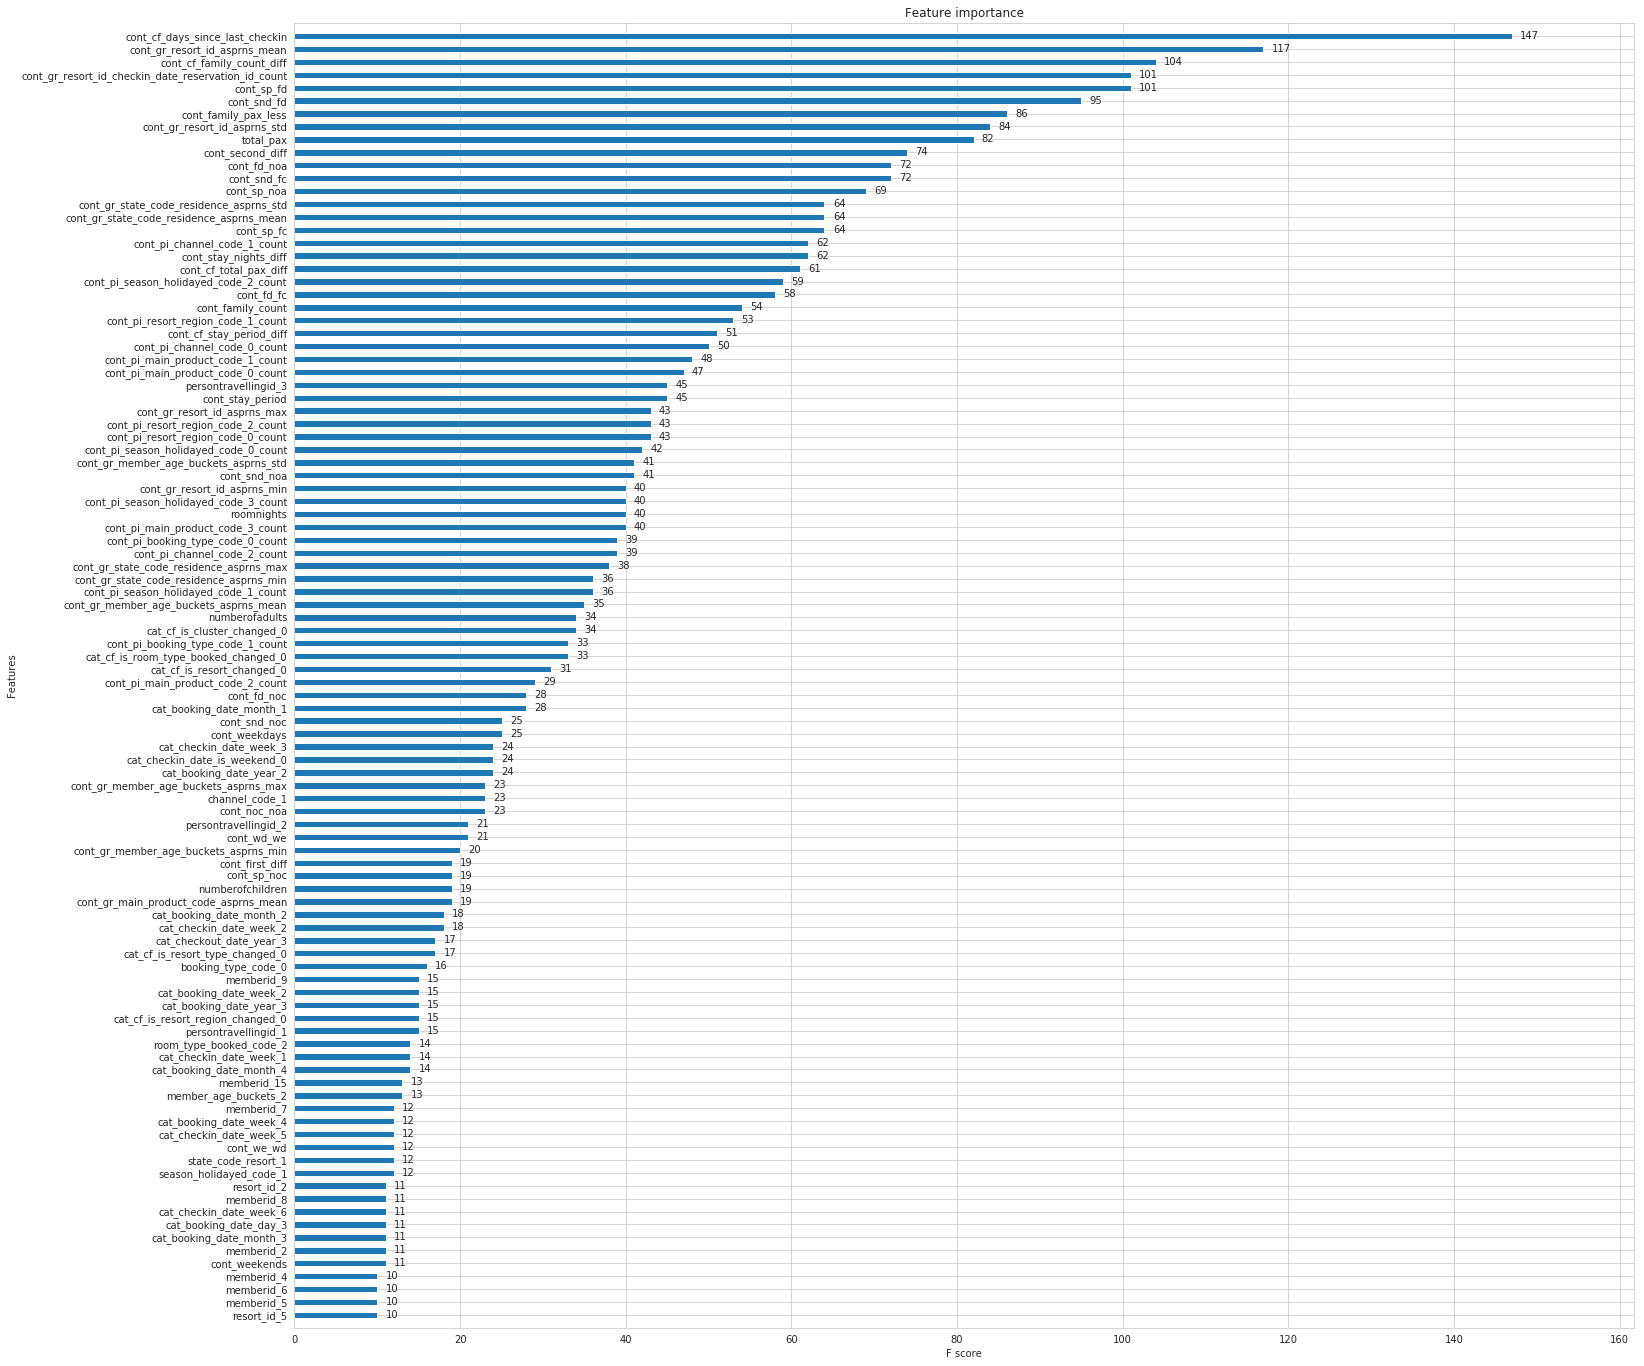

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(24, 24)
xgb.plot_importance(reg_xgb, ax=ax, max_num_features=100, height=0.5);

## Lgbm

In [22]:
df_train_dataset = pd.read_pickle('data/df/df_train_dataset.pkl')
df_validation_dataset = pd.read_pickle('data/df/df_validation_dataset.pkl')

In [23]:
continuous_features = joblib.load('data/iterables/continuous_features.joblib')
categorical_features = joblib.load('data/iterables/categorical_features.joblib')
target_features = joblib.load('data/iterables/target_features.joblib')
target_transformer = joblib.load('models/preprocessing/target_transformer.joblib')

In [24]:
df_train_dataset.shape, df_validation_dataset.shape

((338192, 294), (146765, 294))

In [25]:
X = df_train_dataset[categorical_features + continuous_features]
y = df_train_dataset[target_features].values.flatten()
print(X.shape, y.shape)

(338192, 107) (338192,)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, shuffle=True, random_state=10)

# https://github.com/scikit-learn/scikit-learn/issues/8723
X_train = X_train.copy()
X_test = X_test.copy()

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(270553, 107) (67639, 107) (270553,) (67639,)


In [27]:
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

In [28]:
feature_names = categorical_features + continuous_features
reg_lgbm, y_pred, score = run_lgbm(X_train, X_test, y_train, y_test, feature_names, categorical_features)
print('mse', score, 'rmse', score ** .5)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['booking_type_code', 'cat_are_all_travelling', 'cat_booking_date_day', 'cat_booking_date_is_weekend', 'cat_booking_date_month', 'cat_booking_date_week', 'cat_booking_date_weekday', 'cat_booking_date_year', 'cat_cf_is_cluster_changed', 'cat_cf_is_resort_changed', 'cat_cf_is_resort_region_changed', 'cat_cf_is_resort_type_changed', 'cat_cf_is_room_type_booked_changed', 'cat_cf_is_season_holidayed_changed', 'cat_cf_is_state_resort_changed', 'cat_checkin_date_day', 'cat_checkin_date_is_weekend', 'cat_checkin_date_month', 'cat_checkin_date_week', 'cat_checkin_date_weekday', 'cat_checkin_date_year', 'cat_checkout_date_day', 'cat_checkout_date_is_weekend', 'cat_checkout_date_month', 'cat_checkout_date_week', 'cat_checkout_date_weekday', 'cat_checkout_date_year', 'cat_has_children', 'cat_stay_nights_diff', 'channel_code', 'cluster_co

[1]	valid_0's rmse: 0.134535
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's rmse: 0.133175
[3]	valid_0's rmse: 0.132074
[4]	valid_0's rmse: 0.131136
[5]	valid_0's rmse: 0.130352
[6]	valid_0's rmse: 0.129629
[7]	valid_0's rmse: 0.129006
[8]	valid_0's rmse: 0.128506
[9]	valid_0's rmse: 0.128037
[10]	valid_0's rmse: 0.127638
[11]	valid_0's rmse: 0.127316
[12]	valid_0's rmse: 0.126983
[13]	valid_0's rmse: 0.126695
[14]	valid_0's rmse: 0.126453
[15]	valid_0's rmse: 0.126258
[16]	valid_0's rmse: 0.126063
[17]	valid_0's rmse: 0.125895
[18]	valid_0's rmse: 0.125722
[19]	valid_0's rmse: 0.125577
[20]	valid_0's rmse: 0.12544
[21]	valid_0's rmse: 0.125315
[22]	valid_0's rmse: 0.125199
[23]	valid_0's rmse: 0.125109
[24]	valid_0's rmse: 0.125007
[25]	valid_0's rmse: 0.124932
[26]	valid_0's rmse: 0.124846
[27]	valid_0's rmse: 0.124772
[28]	valid_0's rmse: 0.1247
[29]	valid_0's rmse: 0.124636
[30]	valid_0's rmse: 0.124581
[31]	valid_0's rmse: 0.124531
[32]	valid_0's rmse:

In [29]:
y_pred_val = reg_lgbm.predict(df_validation_dataset[categorical_features + continuous_features].values, reg_lgbm.best_iteration)
y_pred_val = target_transformer.inverse_transform(np.expand_dims(y_pred_val, axis=1))

In [30]:
df_validation_dataset[target_features] = y_pred_val
df_validation_dataset[['reservation_id', 'amount_spent_per_room_night_scaled']].to_csv('submission.csv', index=False)

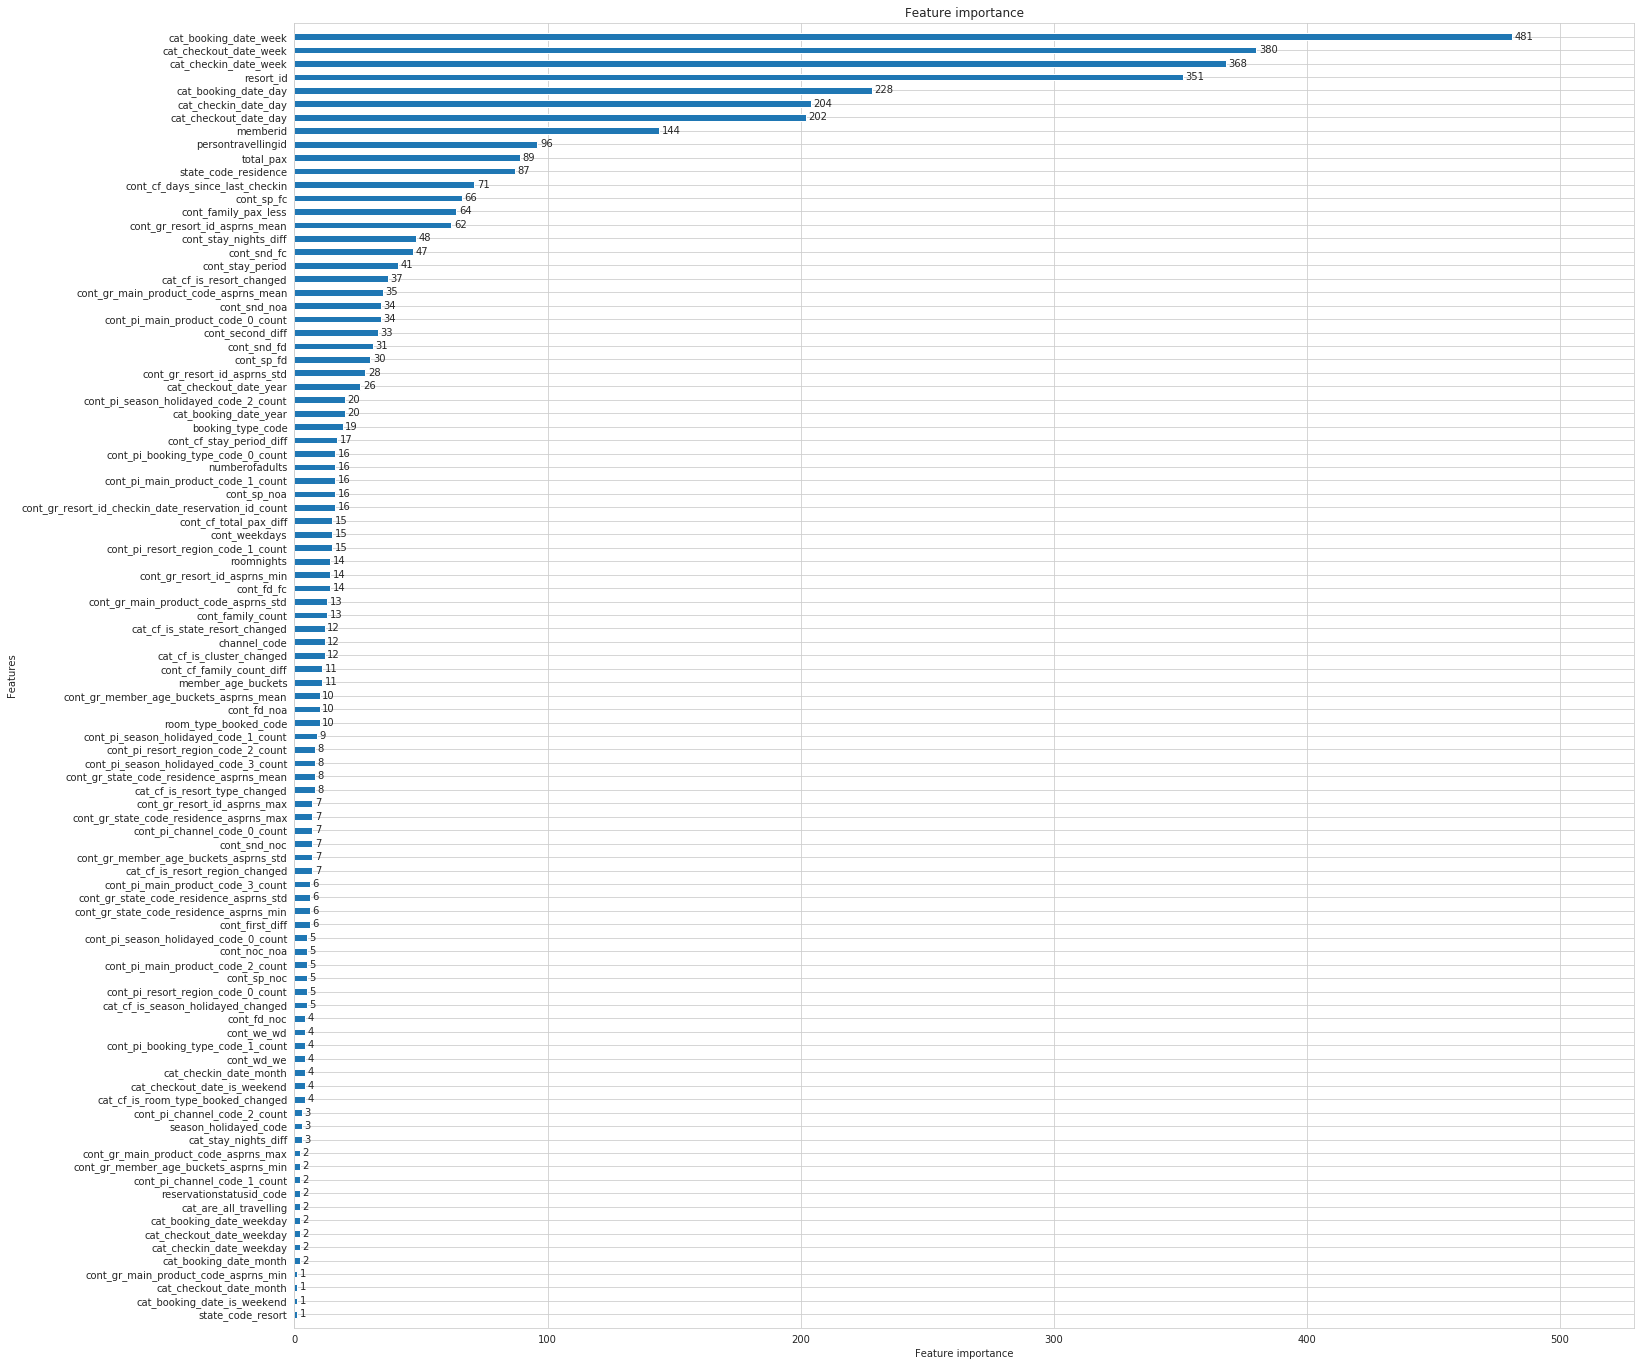

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(24, 24)
lgb.plot_importance(reg_lgbm, ax=ax, height=0.5, max_num_features=100);

## Catboost

In [38]:
feature_names = categorical_features + continuous_features
cat_features = [i for i, c in enumerate(feature_names) if c in categorical_features]
reg_catb, y_pred, score = run_catb(X_train, X_test, y_train, y_test, feature_names, cat_features)
print('mse', score, 'rmse', score ** .5)

0:	learn: 2.0969338	test: 2.0957568	best: 2.0957568 (0)	total: 144ms	remaining: 43.2s
1:	learn: 2.0343070	test: 2.0331304	best: 2.0331304 (1)	total: 343ms	remaining: 51.2s
2:	learn: 1.9735700	test: 1.9723949	best: 1.9723949 (2)	total: 564ms	remaining: 55.9s
3:	learn: 1.9146573	test: 1.9134850	best: 1.9134850 (3)	total: 699ms	remaining: 51.7s
4:	learn: 1.8575216	test: 1.8563512	best: 1.8563512 (4)	total: 863ms	remaining: 50.9s
5:	learn: 1.8021070	test: 1.8009389	best: 1.8009389 (5)	total: 882ms	remaining: 43.2s
6:	learn: 1.7483649	test: 1.7471992	best: 1.7471992 (6)	total: 931ms	remaining: 39s
7:	learn: 1.6962399	test: 1.6950785	best: 1.6950785 (7)	total: 1.14s	remaining: 41.7s
8:	learn: 1.6456931	test: 1.6445336	best: 1.6445336 (8)	total: 1.21s	remaining: 39s
9:	learn: 1.5966731	test: 1.5954937	best: 1.5954937 (9)	total: 1.37s	remaining: 39.7s
10:	learn: 1.5491282	test: 1.5479491	best: 1.5479491 (10)	total: 1.56s	remaining: 40.9s
11:	learn: 1.5030256	test: 1.5018493	best: 1.5018493 (11

95:	learn: 0.1752463	test: 0.1751999	best: 0.1751999 (95)	total: 15.4s	remaining: 32.7s
96:	learn: 0.1729114	test: 0.1728871	best: 0.1728871 (96)	total: 15.6s	remaining: 32.7s
97:	learn: 0.1706776	test: 0.1706747	best: 0.1706747 (97)	total: 15.9s	remaining: 32.7s
98:	learn: 0.1685038	test: 0.1685224	best: 0.1685224 (98)	total: 16.1s	remaining: 32.7s
99:	learn: 0.1664433	test: 0.1664804	best: 0.1664804 (99)	total: 16.3s	remaining: 32.7s
100:	learn: 0.1644750	test: 0.1645310	best: 0.1645310 (100)	total: 16.6s	remaining: 32.7s
101:	learn: 0.1625917	test: 0.1626662	best: 0.1626662 (101)	total: 16.8s	remaining: 32.6s
102:	learn: 0.1607911	test: 0.1608841	best: 0.1608841 (102)	total: 17s	remaining: 32.6s
103:	learn: 0.1590526	test: 0.1591703	best: 0.1591703 (103)	total: 17.3s	remaining: 32.6s
104:	learn: 0.1574279	test: 0.1575658	best: 0.1575658 (104)	total: 17.5s	remaining: 32.5s
105:	learn: 0.1559433	test: 0.1561024	best: 0.1561024 (105)	total: 17.6s	remaining: 32.2s
106:	learn: 0.1544894	

187:	learn: 0.1258933	test: 0.1255081	best: 0.1255081 (187)	total: 35.6s	remaining: 21.2s
188:	learn: 0.1258611	test: 0.1254703	best: 0.1254703 (188)	total: 35.8s	remaining: 21s
189:	learn: 0.1258309	test: 0.1254250	best: 0.1254250 (189)	total: 36.1s	remaining: 20.9s
190:	learn: 0.1258007	test: 0.1253865	best: 0.1253865 (190)	total: 36.3s	remaining: 20.7s
191:	learn: 0.1257694	test: 0.1253469	best: 0.1253469 (191)	total: 36.5s	remaining: 20.5s
192:	learn: 0.1257367	test: 0.1253043	best: 0.1253043 (192)	total: 36.7s	remaining: 20.4s
193:	learn: 0.1257055	test: 0.1252621	best: 0.1252621 (193)	total: 36.9s	remaining: 20.2s
194:	learn: 0.1256387	test: 0.1252193	best: 0.1252193 (194)	total: 37.2s	remaining: 20s
195:	learn: 0.1256073	test: 0.1251842	best: 0.1251842 (195)	total: 37.5s	remaining: 19.9s
196:	learn: 0.1255806	test: 0.1251516	best: 0.1251516 (196)	total: 37.7s	remaining: 19.7s
197:	learn: 0.1255520	test: 0.1251157	best: 0.1251157 (197)	total: 37.9s	remaining: 19.5s
198:	learn: 0.

279:	learn: 0.1238933	test: 0.1240987	best: 0.1240987 (279)	total: 1m 2s	remaining: 4.46s
280:	learn: 0.1238884	test: 0.1240948	best: 0.1240948 (280)	total: 1m 2s	remaining: 4.24s
281:	learn: 0.1238813	test: 0.1240908	best: 0.1240908 (281)	total: 1m 2s	remaining: 4.01s
282:	learn: 0.1238758	test: 0.1240858	best: 0.1240858 (282)	total: 1m 3s	remaining: 3.79s
283:	learn: 0.1238690	test: 0.1240811	best: 0.1240811 (283)	total: 1m 3s	remaining: 3.57s
284:	learn: 0.1238637	test: 0.1240782	best: 0.1240782 (284)	total: 1m 3s	remaining: 3.35s
285:	learn: 0.1238588	test: 0.1240748	best: 0.1240748 (285)	total: 1m 3s	remaining: 3.12s
286:	learn: 0.1238448	test: 0.1240644	best: 0.1240644 (286)	total: 1m 4s	remaining: 2.91s
287:	learn: 0.1238382	test: 0.1240592	best: 0.1240592 (287)	total: 1m 4s	remaining: 2.68s
288:	learn: 0.1238226	test: 0.1240513	best: 0.1240513 (288)	total: 1m 4s	remaining: 2.47s
289:	learn: 0.1238164	test: 0.1240466	best: 0.1240466 (289)	total: 1m 5s	remaining: 2.24s
290:	learn

In [40]:
feature_names = categorical_features + continuous_features
cat_features = [i for i, c in enumerate(feature_names) if c in categorical_features]
val_pool = catboost.Pool(df_validation_dataset[categorical_features + continuous_features].values, feature_names=feature_names, cat_features=cat_features)
y_pred_val = reg_catb.predict(val_pool)
y_pred_val = target_transformer.inverse_transform(np.expand_dims(y_pred_val, axis=1))

In [17]:
df_validation_dataset[target_features] = y_pred_val
df_validation_dataset[['reservation_id', 'amount_spent_per_room_night_scaled']].to_csv('submission.csv', index=False)